In [1]:
import heapq

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')


In [2]:
# M/D/1 queue

import scipy.stats as sts


class Queue:
    def __init__(self, service_rate):
        # Store the deterministic service time for an M/D/1 queue
        self.service_time = 1 / service_rate
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0

    def add_customer(self, schedule):
        # Add the customer to the queue
        self.people_in_queue += 1
        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_time,
            self.finish_serving_customer)
            
    def finish_serving_customer(self, schedule):
        # Remove the customer from the server
        self.people_being_served -= 1
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)


class GroceryStore:
    
    def __init__(self, arrival_rate, service_rate):
        self.queue = Queue(service_rate)
        self.arrival_distribution = sts.expon(scale=1/arrival_rate)

    def add_customer(self, schedule):
        # Add this customer to the queue
        self.queue.add_customer(schedule)
        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        

def run_simulation(arrival_rate, service_rate, run_until):
    schedule = Schedule()
    grocery_store = GroceryStore(arrival_rate, service_rate)
    grocery_store.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    return grocery_store

In [3]:
# Run a short test
grocery_store = run_simulation(arrival_rate=1.2, service_rate=1, run_until=100)
print(f'There are {grocery_store.queue.people_in_queue} people in the queue')

There are 12 people in the queue


# Part 1 - Arrival rate: 0.8 & Service rate: 1

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def empirical_study(nr_trails, run_until, arrival_rate, service_rate):
    """This function will run nr_trails simulations, gather all the queue_length, plot in a histogram
    and compute the empirically estimate of the mean queue length"""
    
    #create an empty np array
    queue_length = np.zeros(nr_trails)
    
    #run all the trails
    for i in range(0, nr_trails):
        
        #run a simulation
        grocery_store = run_simulation(arrival_rate=arrival_rate, service_rate=service_rate, run_until=run_until)
        
        #Save the queue length
        queue_length[i] = grocery_store.queue.people_in_queue
    
    plt.figure()
    plt.hist(queue_length)
    plt.xlabel(f"Queue length after {run_until} units of time")
    plt.ylabel("Number of occurances")
    plt.show()
    
    #sample mean
    m = np.mean(queue_length)
    
    #standard error
    t = sts.sem(queue_length)
    
    print(f"With {nr_trails} trails, and an arrival rate of: {round(arrival_rate,4)} and service rate of: {service_rate}")
    print(f"The estimated mean queue length is {round(m,2)} and the 95% confidence interval is {round(m-1.96*t, 2)} - {round(m+1.96*t,2)}")
    
    return (arrival_rate, m, t)
   

# 100 trails

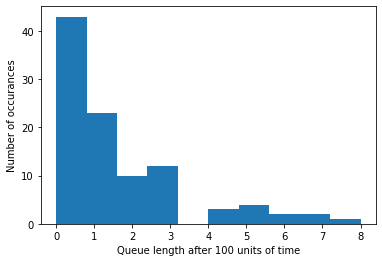

With 100 trails, and an arrival rate of: 0.8 and service rate of: 1
The estimated mean queue length is 1.45 and the 95% confidence interval is 1.09 - 1.81



In [5]:
empirical_study(nr_trails = 100, run_until = 100, arrival_rate = 0.8, service_rate = 1)
print("")

# 1000 trails

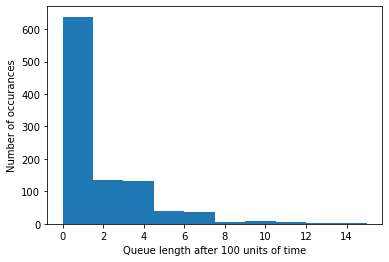

With 1000 trails, and an arrival rate of: 0.8 and service rate of: 1
The estimated mean queue length is 1.52 and the 95% confidence interval is 1.39 - 1.65



In [6]:
empirical_study(nr_trails = 1000, run_until = 100, arrival_rate = 0.8, service_rate = 1)
print("")

# Analysis of the two experiments

a) The overall shape of the histogram distribution remains the same for both 100 and 1000 trails. The main differences is the number of occurances which is scaled with approximatly 10. There is also occurances of more extreme values in the histogram for 1000 trails with extreme values up to approximatly a length of 20

b) The average queue length estimate are quite different between the two empirical studies. The means differ by over 0.1

c) The confidence interval drastically decreased with the increased sample size. This is because the larger sample size.

# Error plot

In [13]:
def error_plot(arrival_rates, service_rate):
    """Run empirical studies with different arrival rates and plots an error plot"""
    
    #empty np array for data
    data = []
    
    #loop through each arrival rate
    for i in range(len(arrival_rates)):
        
        #gets the results for a specific arrival rate
        datum = empirical_study(nr_trails = 100, run_until = 100, arrival_rate = arrival_rates[i], service_rate = service_rate)
        
        #appends to data
        data.append(datum)
    
    #all the values
    x_val = [datum[0] for datum in data]
    y_val = [datum[1] for datum in data]
    y_error = [datum[2]*1.96 for datum in data]
    
    #plot the error 
    plt.figure()
    plt.xlabel("Arrival rate")
    plt.ylabel("Estimated queue length with 95% confidence interval")
    plt.errorbar(
        x_val, y_val, y_error,
        color = "black", marker = "o", capsize = 5, linestyle = "--", linewidth = 1)
    plt.axhline(5, color = "red", linestyle = "--", label = "Queue length of 5")
    plt.legend()
    plt.show()
    
    
    

# Different arrival rates

Below can be found histograms for different arrival rates. 

From the empirical experiments with different arrival rate, a arrival rate of approximatly 0.91 is the largest arrival rate one can have where the upper limit for 95% confidence interval of mean queue length is still below 5

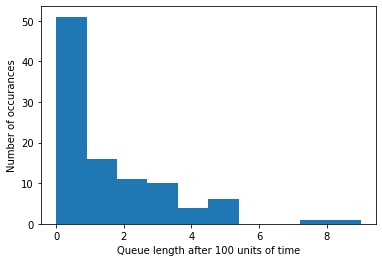

With 100 trails, and an arrival rate of: 0.8 and service rate of: 1
The estimated mean queue length is 1.31 and the 95% confidence interval is 0.95 - 1.67


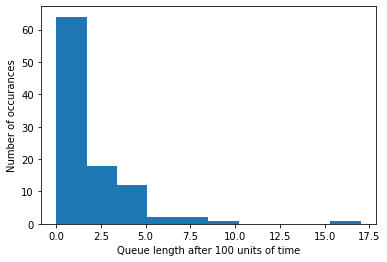

With 100 trails, and an arrival rate of: 0.8222 and service rate of: 1
The estimated mean queue length is 1.69 and the 95% confidence interval is 1.2 - 2.18


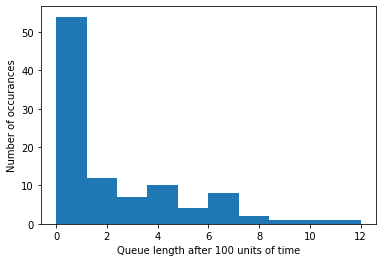

With 100 trails, and an arrival rate of: 0.8444 and service rate of: 1
The estimated mean queue length is 2.22 and the 95% confidence interval is 1.7 - 2.74


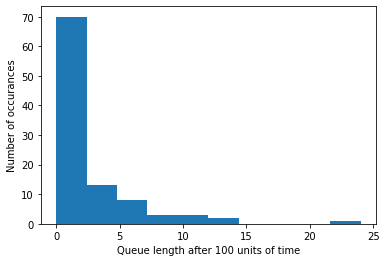

With 100 trails, and an arrival rate of: 0.8667 and service rate of: 1
The estimated mean queue length is 2.47 and the 95% confidence interval is 1.73 - 3.21


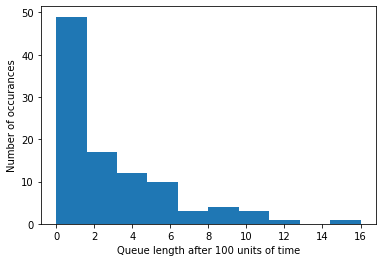

With 100 trails, and an arrival rate of: 0.8889 and service rate of: 1
The estimated mean queue length is 2.7 and the 95% confidence interval is 2.07 - 3.33


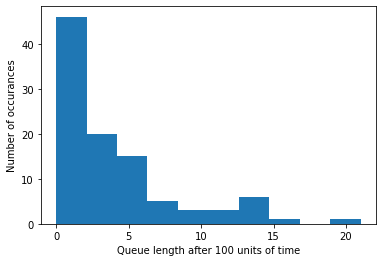

With 100 trails, and an arrival rate of: 0.9111 and service rate of: 1
The estimated mean queue length is 3.96 and the 95% confidence interval is 3.12 - 4.8


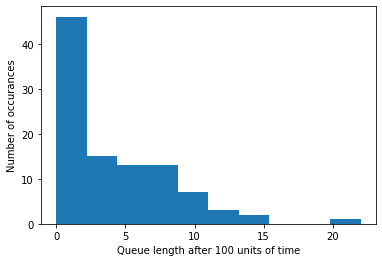

With 100 trails, and an arrival rate of: 0.9333 and service rate of: 1
The estimated mean queue length is 4.04 and the 95% confidence interval is 3.23 - 4.85


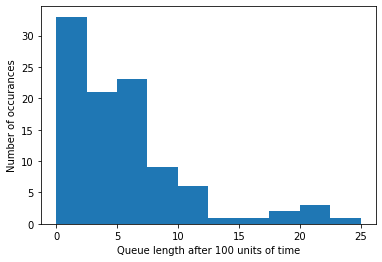

With 100 trails, and an arrival rate of: 0.9556 and service rate of: 1
The estimated mean queue length is 5.33 and the 95% confidence interval is 4.32 - 6.34


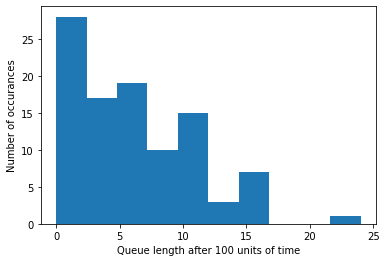

With 100 trails, and an arrival rate of: 0.9778 and service rate of: 1
The estimated mean queue length is 6.08 and the 95% confidence interval is 5.13 - 7.03


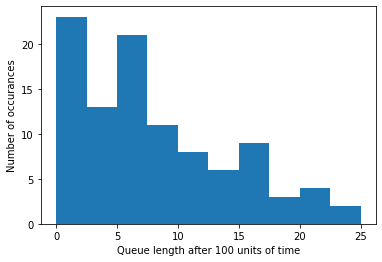

With 100 trails, and an arrival rate of: 1.0 and service rate of: 1
The estimated mean queue length is 7.92 and the 95% confidence interval is 6.69 - 9.15


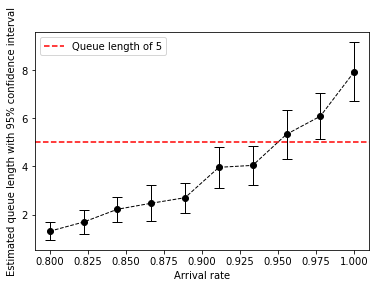

In [14]:
error_plot(np.linspace(0.8,1,10), 1)

# LO's

#EmpiricalAnalysis: As the queue length distribution is not know, I used the Central Limit Theorem, sampling 100 or a 1000 sample queue length to derive a normal distribution of sampled mean which follows the normal distribution. The queue length was sampled after more than 100 run_units to allow to the system to reach equilibrium. The estimated population mean, along with the confidence interval was computed and displayed using a classic error bar graph. 

#Professionalism: Displaying the results was done using parsimonious graphs. All axes was correctly labels. For the error bar plot, I've decided to include a horizontal line that intersects with